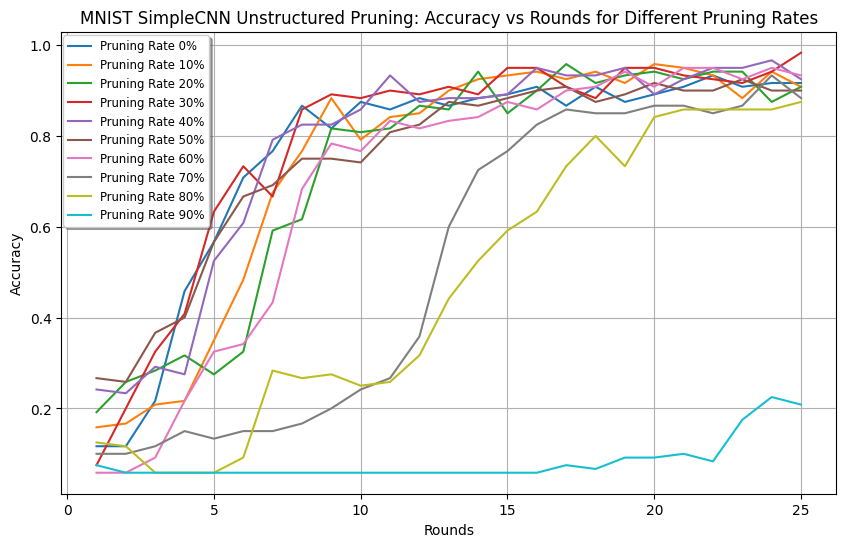

In [26]:
import json
import matplotlib.pyplot as plt

# Load the data from the JSON file
with open('Experimental data/MNIST_SimpleCNN_Unstructured.json') as f:
    data = json.load(f)

# Sort the data by pruning rate in ascending order
data_sorted = sorted(data, key=lambda x: x["pruning_rate"])

# Prepare the plot
plt.figure(figsize=(10, 6))

# Iterate through each entry in the sorted data
for entry in data_sorted:
    pruning_rate = entry["pruning_rate"]
    rounded_pruning_rate = round(pruning_rate * 100)
    rounds_accuracy = entry["history_metrics_distributed_evaluate"]["accuracy"]
    rounds = [item[0] for item in rounds_accuracy]
    accuracy = [item[1] for item in rounds_accuracy]

    # Plot each pruning rate
    plt.plot(rounds, accuracy, label=f'Pruning Rate {rounded_pruning_rate}%')

# Customize the plot
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('MNIST SimpleCNN Unstructured Pruning: Accuracy vs Rounds for Different Pruning Rates')
plt.legend(loc='upper left', bbox_to_anchor=(-0.005, 1.005), frameon=True, fontsize='small', fancybox=True, shadow=True, ncol=1)
plt.grid(True)
plt.show()


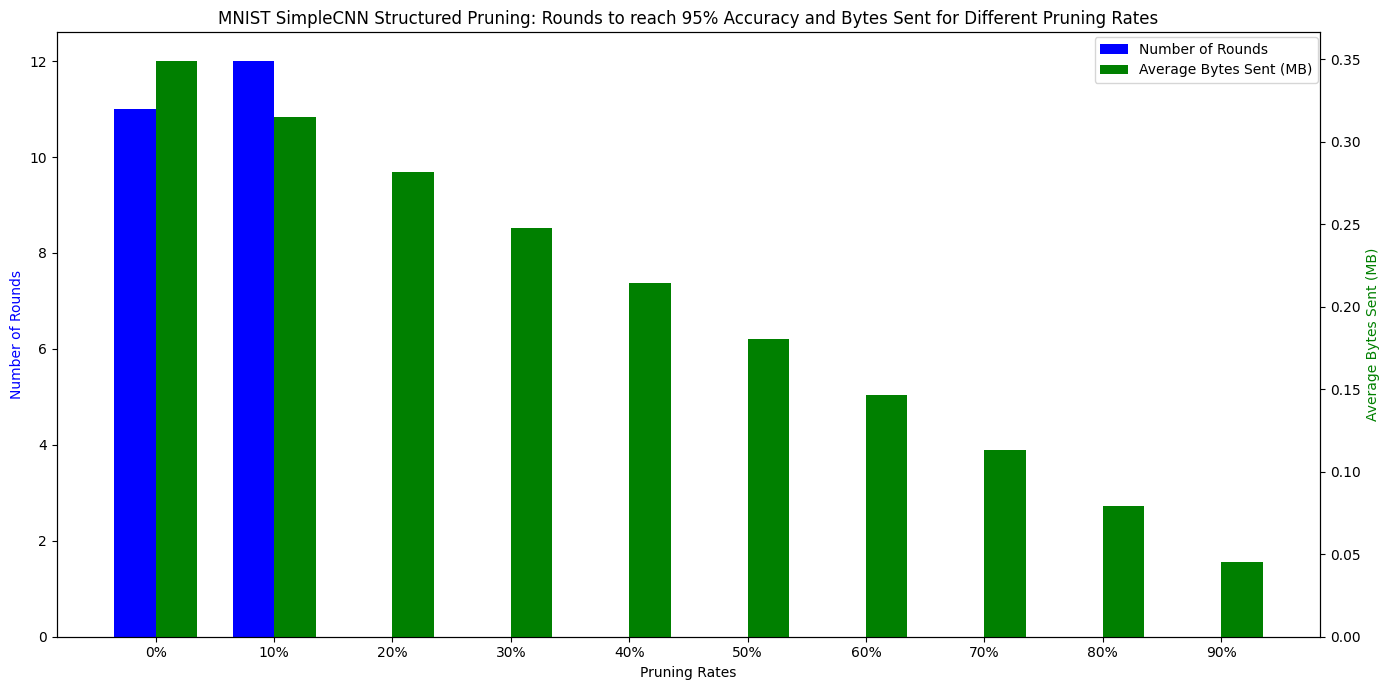

In [32]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the JSON file
with open('Experimental data/MNIST_SimpleCNN_Structured.json') as f:
    data = json.load(f)

# Prepare lists to store the metrics
pruning_rates = []
rounds_to_threshold = []
average_bytes_sent = []
threshold = 0.85
data_sorted = sorted(data, key=lambda x: x["pruning_rate"])

# Iterate through each entry in the data to calculate the required values
for entry in data_sorted:
    pruning_rate = entry["pruning_rate"]
    rounded_pruning_rate = round(pruning_rate * 100)

    # Find the round where accuracy first hits the threshold
    accuracy = entry["history_metrics_centralized"]["accuracy"]
    round_at_threshold = next((item[0] for item in accuracy if item[1] >= threshold), float('inf'))

    # Calculate total bytes sent in megabytes
    bytes_sent = [item[1] for item in entry["history_metrics_distributed_fit"]["bytes sent"]]
    total_bytes_sent_mb = (sum(bytes_sent) / len(bytes_sent)) / 1_048_576 if bytes_sent else 0

    # Store the calculated values
    pruning_rates.append(f'{rounded_pruning_rate}%')
    rounds_to_threshold.append(round_at_threshold)
    average_bytes_sent.append(total_bytes_sent_mb)

# Set up the bar chart
x = np.arange(len(pruning_rates))
width = 0.35

fig, ax1 = plt.subplots(figsize=(14, 7))  # Increased size for better layout

# Bar chart for rounds to threshold
bar1 = ax1.bar(x - width/2, rounds_to_threshold, width, label='Number of Rounds', color='b')

# Bar chart for average bytes sent
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, average_bytes_sent, width, label='Average Bytes Sent (MB)', color='g')

# Add labels, title, and legend
ax1.set_xlabel('Pruning Rates')
ax1.set_ylabel('Number of Rounds', color='b')
ax2.set_ylabel('Average Bytes Sent (MB)', color='g')
ax1.set_title('MNIST SimpleCNN Structured Pruning: Rounds to reach 95% Accuracy and Bytes Sent for Different Pruning Rates')
ax1.set_xticks(x)
ax1.set_xticklabels(pruning_rates)

# Add legends outside the chart
fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95))

# Adjust layout to make room for the legend
fig.tight_layout()

# Show plot
plt.show()


In [3]:
import json
import numpy as np
import pandas as pd
import os

# Define file paths and related details
file_details = [
    ('CIFAR10', 'ResNet12', 'Structured'),
    ('CIFAR10', 'ResNet12', 'Unstructured'),
    ('MNIST', 'ResNet12', 'Structured'),
    ('MNIST', 'ResNet12', 'Unstructured'),
    ('MNIST', 'SimpleCNN', 'Structured'),
    ('MNIST', 'SimpleCNN', 'Unstructured')
]

# Initialize a dictionary to hold the data for the DataFrame
table_data = {
    'Pruning Rate': [],
    'CIFAR10_ResNet12_Structured_Highest Centralized Accuracy': [],
    'CIFAR10_ResNet12_Structured_Avg Bytes Sent': [],
    'CIFAR10_ResNet12_Structured_Round of Highest Accuracy': [],
    'CIFAR10_ResNet12_Unstructured_Highest Centralized Accuracy': [],
    'CIFAR10_ResNet12_Unstructured_Avg Bytes Sent': [],
    'CIFAR10_ResNet12_Unstructured_Round of Highest Accuracy': [],
    'MNIST_ResNet12_Structured_Highest Centralized Accuracy': [],
    'MNIST_ResNet12_Structured_Avg Bytes Sent': [],
    'MNIST_ResNet12_Structured_Round of Highest Accuracy': [],
    'MNIST_ResNet12_Unstructured_Highest Centralized Accuracy': [],
    'MNIST_ResNet12_Unstructured_Avg Bytes Sent': [],
    'MNIST_ResNet12_Unstructured_Round of Highest Accuracy': [],
    'MNIST_SimpleCNN_Structured_Highest Centralized Accuracy': [],
    'MNIST_SimpleCNN_Structured_Avg Bytes Sent': [],
    'MNIST_SimpleCNN_Structured_Round of Highest Accuracy': [],
    'MNIST_SimpleCNN_Unstructured_Highest Centralized Accuracy': [],
    'MNIST_SimpleCNN_Unstructured_Avg Bytes Sent': [],
    'MNIST_SimpleCNN_Unstructured_Round of Highest Accuracy': []
}

# Iterate over the files and fill the table_data
for dataset, model, pruning in file_details:
    filename = f"{dataset}_{model}_{pruning}.json"
    
    with open(os.path.join('Experimental data/', filename)) as f:
        data = json.load(f)
    
    for entry in data:
        pruning_rate = round(entry["pruning_rate"] * 100)

        # Calculate average size in bytes sent
        avg_size_in_bytes = np.mean([item[1] for item in entry["history_metrics_distributed_fit"]["bytes sent"]])

        # Find the highest centralized accuracy and its corresponding round
        centralized_accuracy = entry["history_metrics_centralized"]["accuracy"]
        highest_centralized_accuracy = max(centralized_accuracy, key=lambda x: x[1])
        highest_centralized_accuracy_value = highest_centralized_accuracy[1]
        round_of_highest_centralized_accuracy = highest_centralized_accuracy[0]

        # Fill the pruning rate if it's not already in the table_data
        if f'{pruning_rate}%' not in table_data['Pruning Rate']:
            table_data['Pruning Rate'].append(f'{pruning_rate}%')

        # Fill the metrics in the corresponding columns
        col_prefix = f"{dataset}_{model}_{pruning}_"
        table_data[col_prefix + 'Highest Centralized Accuracy'].append(highest_centralized_accuracy_value)
        table_data[col_prefix + 'Avg Bytes Sent'].append(avg_size_in_bytes)
        table_data[col_prefix + 'Round of Highest Accuracy'].append(round_of_highest_centralized_accuracy)

# Convert the dictionary to a DataFrame
df = pd.DataFrame(table_data)

# Print the DataFrame as a table
print(df.to_string(index=False))


Pruning Rate  CIFAR10_ResNet12_Structured_Highest Centralized Accuracy  CIFAR10_ResNet12_Structured_Avg Bytes Sent  CIFAR10_ResNet12_Structured_Round of Highest Accuracy  CIFAR10_ResNet12_Unstructured_Highest Centralized Accuracy  CIFAR10_ResNet12_Unstructured_Avg Bytes Sent  CIFAR10_ResNet12_Unstructured_Round of Highest Accuracy  MNIST_ResNet12_Structured_Highest Centralized Accuracy  MNIST_ResNet12_Structured_Avg Bytes Sent  MNIST_ResNet12_Structured_Round of Highest Accuracy  MNIST_ResNet12_Unstructured_Highest Centralized Accuracy  MNIST_ResNet12_Unstructured_Avg Bytes Sent  MNIST_ResNet12_Unstructured_Round of Highest Accuracy  MNIST_SimpleCNN_Structured_Highest Centralized Accuracy  MNIST_SimpleCNN_Structured_Avg Bytes Sent  MNIST_SimpleCNN_Structured_Round of Highest Accuracy  MNIST_SimpleCNN_Unstructured_Highest Centralized Accuracy  MNIST_SimpleCNN_Unstructured_Avg Bytes Sent  MNIST_SimpleCNN_Unstructured_Round of Highest Accuracy
         10%                                 

In [28]:
import json
import numpy as np
import pandas as pd
import os

# Define file paths and related details
file_details = [
    ('CIFAR10', 'ResNet12', 'Structured'),
    ('CIFAR10', 'ResNet12', 'Unstructured'),
    ('MNIST', 'ResNet12', 'Structured'),
    ('MNIST', 'ResNet12', 'Unstructured'),
    ('MNIST', 'SimpleCNN', 'Structured'),
    ('MNIST', 'SimpleCNN', 'Unstructured')
]

# Initialize a dictionary to hold the data for the DataFrame
table_data = {
    'Pruning Rate': []
}

# Iterate over the files and fill the table_data
for dataset, model, pruning in file_details:
    filename = f"{dataset}_{model}_{pruning}.json"
    
    with open(os.path.join('Experimental data/', filename)) as f:
        data = json.load(f)
    
    col_prefix = f"{dataset}_{model}_{pruning}"
    
    # Prepare columns for each file's data
    table_data[f"{col_prefix}_Highest Centralized Accuracy"] = []
    table_data[f"{col_prefix}_Avg Bytes Sent"] = []
    table_data[f"{col_prefix}_Round of Highest Accuracy"] = []

    for entry in data:
        pruning_rate = round(entry["pruning_rate"] * 100)

        # Calculate average size in bytes sent
        avg_size_in_bytes = round(np.mean([item[1] for item in entry["history_metrics_distributed_fit"]["bytes sent"]])/1_048_576,2)

        # Find the highest centralized accuracy and its corresponding round
        centralized_accuracy = entry["history_metrics_centralized"]["accuracy"]
        highest_centralized_accuracy = max(centralized_accuracy, key=lambda x: x[1])
        highest_centralized_accuracy_value = round(highest_centralized_accuracy[1],2)
        round_of_highest_centralized_accuracy = highest_centralized_accuracy[0]

        # Fill the pruning rate if it's not already in the table_data
        if f'{pruning_rate}%' not in table_data['Pruning Rate']:
            table_data['Pruning Rate'].append(f'{pruning_rate}%')

        # Append data to the respective columns
        table_data[f"{col_prefix}_Highest Centralized Accuracy"].append(highest_centralized_accuracy_value)
        table_data[f"{col_prefix}_Avg Bytes Sent"].append(avg_size_in_bytes)
        table_data[f"{col_prefix}_Round of Highest Accuracy"].append(round_of_highest_centralized_accuracy)

# Convert the dictionary to a DataFrame
df = pd.DataFrame(table_data)

# Sort the DataFrame by the 'Pruning Rate' in ascending order
df = df.sort_values('Pruning Rate').reset_index(drop=True)

# Format the table with MultiIndex columns
columns = pd.MultiIndex.from_tuples([
    ('Pruning Rate', ''),
    ('CIFAR10_ResNet12_Structured', 'Accuracy'),
    ('CIFAR10_ResNet12_Structured', 'Data Size (MB)'),
    ('CIFAR10_ResNet12_Structured', 'Round'),
    ('CIFAR10_ResNet12_Unstructured', 'Accuracy'),
    ('CIFAR10_ResNet12_Unstructured', 'Data Size (MB)'),
    ('CIFAR10_ResNet12_Unstructured', 'Round'),
    ('MNIST_ResNet12_Structured', 'Accuracy'),
    ('MNIST_ResNet12_Structured', 'Data Size (MB)'),
    ('MNIST_ResNet12_Structured', 'Round'),
    ('MNIST_ResNet12_Unstructured', 'Accuracy'),
    ('MNIST_ResNet12_Unstructured', 'Data Size (MB)'),
    ('MNIST_ResNet12_Unstructured', 'Round'),
    ('MNIST_SimpleCNN_Structured', 'Accuracy'),
    ('MNIST_SimpleCNN_Structured', 'Data Size (MB)'),
    ('MNIST_SimpleCNN_Structured', 'Round'),
    ('MNIST_SimpleCNN_Unstructured', 'Accuracy'),
    ('MNIST_SimpleCNN_Unstructured', 'Data Size (MB)'),
    ('MNIST_SimpleCNN_Unstructured', 'Round')
])


df.columns = columns

# Print the DataFrame formatted for easy copying into a Word document
print(df.to_string(index=False))


Pruning Rate CIFAR10_ResNet12_Structured                      CIFAR10_ResNet12_Unstructured                      MNIST_ResNet12_Structured                      MNIST_ResNet12_Unstructured                      MNIST_SimpleCNN_Structured                      MNIST_SimpleCNN_Unstructured                     
                                Accuracy Data Size (MB) Round                      Accuracy Data Size (MB) Round                  Accuracy Data Size (MB) Round                    Accuracy Data Size (MB) Round                   Accuracy Data Size (MB) Round                     Accuracy Data Size (MB) Round
          0%                        0.40         155.75    29                          0.38         155.75    49                      0.97         155.74    29                        0.97         155.74    15                       0.92           0.35    20                         0.93           0.35    22
         10%                        0.36         138.40    79                  

In [30]:
import pandas as pd

# Specify the path and file name for the Excel file
output_file = 'output_data_multiindex.xlsx'

# Create an Excel writer object with XlsxWriter engine
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    # Write DataFrame without headers
    df.to_excel(writer, index=True, header=False, startrow=3)
    
    # Access the XlsxWriter workbook and worksheet
    workbook  = writer.book
    worksheet = writer.sheets['Sheet1']
    
    # Define formats for the headers
    header_format = workbook.add_format({'bold': True, 'text_wrap': True, 'valign': 'top', 'align': 'center'})
    
    # Define the MultiIndex headers
    top_level_headers = df.columns.get_level_values(0).unique()
    second_level_headers = df.columns.get_level_values(1)
    
    # Write the top-level MultiIndex headers
    for col_num, value in enumerate(top_level_headers):
        worksheet.merge_range(0, col_num * len(top_level_headers), 0, col_num * len(top_level_headers) + len(top_level_headers) - 1, value, header_format)
    
    # Write the second-level headers
    for col_num, value in enumerate(second_level_headers):
        worksheet.write(1, col_num, value, header_format)
    
    # Adjust column widths for readability
    for col_num in range(len(df.columns)):
        worksheet.set_column(col_num, col_num, 20)

# Notify that the file has been saved
print(f"DataFrame with MultiIndex columns has been saved to {output_file}")


NotImplementedError: Writing to Excel with MultiIndex columns and no index ('index'=False) is not yet implemented.